### Import packages

In [3]:
# Load packages
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
batch_size = 64

### Load Data

In [4]:
# Load data
stanford_dogs, ds_info = tfds.load('stanford_dogs', with_info=True, as_supervised=True)

ds_train, ds_test = stanford_dogs['train'], stanford_dogs['test']


print(ds_info)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around the
    world. This dataset has been built using images and annotation from ImageNet for
    the task of fine-grained image categorization. There are 20,580 images, out of
    which 12,000 are used for training and 8580 for testing. Class labels and
    bounding box annotations are provided for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_dir='/root/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
            'bbox': B

In [5]:
num_classes = ds_info.features["label"].num_classes

In [6]:
num_classes

120

### Data preprocessing (resizing, nomalize)

In [7]:
# preprocess for AlexNet
def preprocess_input_alexnet(image,label):
    image = tf.image.resize(image, (227, 227))  # resize to 277*277
    image = image / 255.0 # Normalize pixel values
    return image,label

In [8]:
# Preprocess for ResNet50
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) #resize to 224*224
    image = preprocess_input(image) #build in preprocess
    return image, label

In [9]:
# transfrom for AlexNet
train_set_an = ds_train.map(preprocess_input_alexnet).shuffle(1000).batch(batch_size).prefetch(1)
test_set_an = ds_test.map(preprocess_input_alexnet).batch(batch_size).prefetch(1)

In [10]:
# transform for ResNet50
train_set = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(1)
test_set = ds_test.map(preprocess).batch(batch_size).prefetch(1)

In [11]:
# check shape for AlexNet
for images, labels in train_set_an.take(1):
    print('Image batch shape:', images.shape)
    print('Label batch shape:', labels.shape)

Image batch shape: (64, 227, 227, 3)
Label batch shape: (64,)


In [12]:
# check shape for ResNet50
for images, labels in train_set.take(1):
    print('Image batch shape:', images.shape)
    print('Label batch shape:', labels.shape)

Image batch shape: (64, 224, 224, 3)
Label batch shape: (64,)


### Build and run AlexNet model

In [51]:
# alexnet model
alexnet_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(48,(3,3), activation='relu', padding='same', input_shape=(227,227,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(192, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

# Compile the model
alexnet_model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
alexnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 227, 227, 48)      1344      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 113, 113, 48)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 113, 113, 128)     55424     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 192)       221376    
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 192)      

In [52]:
alexnet_history = alexnet_model.fit(
    train_set_an,
    epochs = 10,
    validation_data=test_set_an
)

Epoch 1/10
188/188 [==============================] - 85s 394ms/step - loss: 4.8137 - accuracy: 0.0069 - val_loss: 4.7873 - val_accuracy: 0.0058
Epoch 2/10
188/188 [==============================] - 66s 341ms/step - loss: 4.7889 - accuracy: 0.0066 - val_loss: 4.7875 - val_accuracy: 0.0066
Epoch 3/10
188/188 [==============================] - 65s 340ms/step - loss: 4.7884 - accuracy: 0.0068 - val_loss: 4.7875 - val_accuracy: 0.0058
Epoch 4/10
188/188 [==============================] - 73s 384ms/step - loss: 4.7882 - accuracy: 0.0061 - val_loss: 4.7874 - val_accuracy: 0.0058
Epoch 5/10
188/188 [==============================] - 67s 349ms/step - loss: 4.7882 - accuracy: 0.0047 - val_loss: 4.7875 - val_accuracy: 0.0075
Epoch 6/10
188/188 [==============================] - 76s 397ms/step - loss: 4.7882 - accuracy: 0.0072 - val_loss: 4.7876 - val_accuracy: 0.0063
Epoch 7/10
188/188 [==============================] - 70s 364ms/step - loss: 4.7882 - accuracy: 0.0059 - val_loss: 4.7875 - val_ac

### Build and run ResNet50 model

In [30]:
# Create the base ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

resnet_50_2_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_50_2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
resnet_50_2_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [31]:
resnet_50_2_model_history = resnet_50_2_model.fit(
    train_set,
    epochs=10,
    validation_data=test_set
)

Epoch 1/10
188/188 [==============================] - 120s 435ms/step - loss: 1.4706 - accuracy: 0.6111 - val_loss: 0.8960 - val_accuracy: 0.7305
Epoch 2/10
188/188 [==============================] - 94s 476ms/step - loss: 0.5460 - accuracy: 0.8273 - val_loss: 0.8444 - val_accuracy: 0.7460
Epoch 3/10
188/188 [==============================] - 85s 433ms/step - loss: 0.3270 - accuracy: 0.8923 - val_loss: 0.8701 - val_accuracy: 0.7491
Epoch 4/10
188/188 [==============================] - 84s 431ms/step - loss: 0.2066 - accuracy: 0.9307 - val_loss: 0.8349 - val_accuracy: 0.7618
Epoch 5/10
188/188 [==============================] - 83s 425ms/step - loss: 0.1274 - accuracy: 0.9604 - val_loss: 0.8627 - val_accuracy: 0.7728
Epoch 6/10
188/188 [==============================] - 82s 416ms/step - loss: 0.0838 - accuracy: 0.9762 - val_loss: 0.8663 - val_accuracy: 0.7709
Epoch 7/10
188/188 [==============================] - 95s 476ms/step - loss: 0.0639 - accuracy: 0.9830 - val_loss: 0.9274 - val_a

In [7]:
# Preprocess for New ResNet50
def preprocess_tune(image, label):
    image = tf.image.resize(image, (300, 300)) #resize to 280*280
    image = preprocess_input(image) #build in preprocess
    return image, label

In [8]:
# transform for New ResNet50
train_set_tune = ds_train.map(preprocess_tune).shuffle(1000).batch(batch_size).prefetch(1)
test_set_tune = ds_test.map(preprocess_tune).batch(batch_size).prefetch(1)

In [9]:
# check shape for New ResNet50
for images, labels in train_set_tune.take(1):
    print('Image batch shape:', images.shape)
    print('Label batch shape:', labels.shape)

Image batch shape: (64, 300, 300, 3)
Label batch shape: (64,)


In [10]:
#add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [11]:
# Create the base ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Create the custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

resnet_50_3_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_50_3_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
resnet_50_3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 306, 306, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [12]:
# Fit the model with the early stopping callback
resnet_50_3_model_history = resnet_50_3_model.fit(
    train_set_tune,
    epochs=10,
    validation_data=test_set_tune,
    callbacks=[early_stopping]
)

Epoch 1/10
188/188 [==============================] - 151s 700ms/step - loss: 1.4292 - accuracy: 0.6346 - val_loss: 0.7125 - val_accuracy: 0.7851
Epoch 2/10
188/188 [==============================] - 167s 858ms/step - loss: 0.4523 - accuracy: 0.8598 - val_loss: 0.6646 - val_accuracy: 0.8000
Epoch 3/10
188/188 [==============================] - 135s 689ms/step - loss: 0.2725 - accuracy: 0.9098 - val_loss: 0.6685 - val_accuracy: 0.7965
Epoch 4/10
188/188 [==============================] - 167s 862ms/step - loss: 0.1765 - accuracy: 0.9451 - val_loss: 0.6478 - val_accuracy: 0.8050
Epoch 5/10
188/188 [==============================] - 135s 692ms/step - loss: 0.1083 - accuracy: 0.9683 - val_loss: 0.6690 - val_accuracy: 0.8101
Epoch 6/10
188/188 [==============================] - 134s 688ms/step - loss: 0.0823 - accuracy: 0.9769 - val_loss: 0.6500 - val_accuracy: 0.8188
Epoch 7/10
188/188 [==============================] - 136s 692ms/step - loss: 0.0534 - accuracy: 0.9859 - val_loss: 0.6807 -

### Confusion Matrix

135/135 [==============================] - 60s 446ms/step


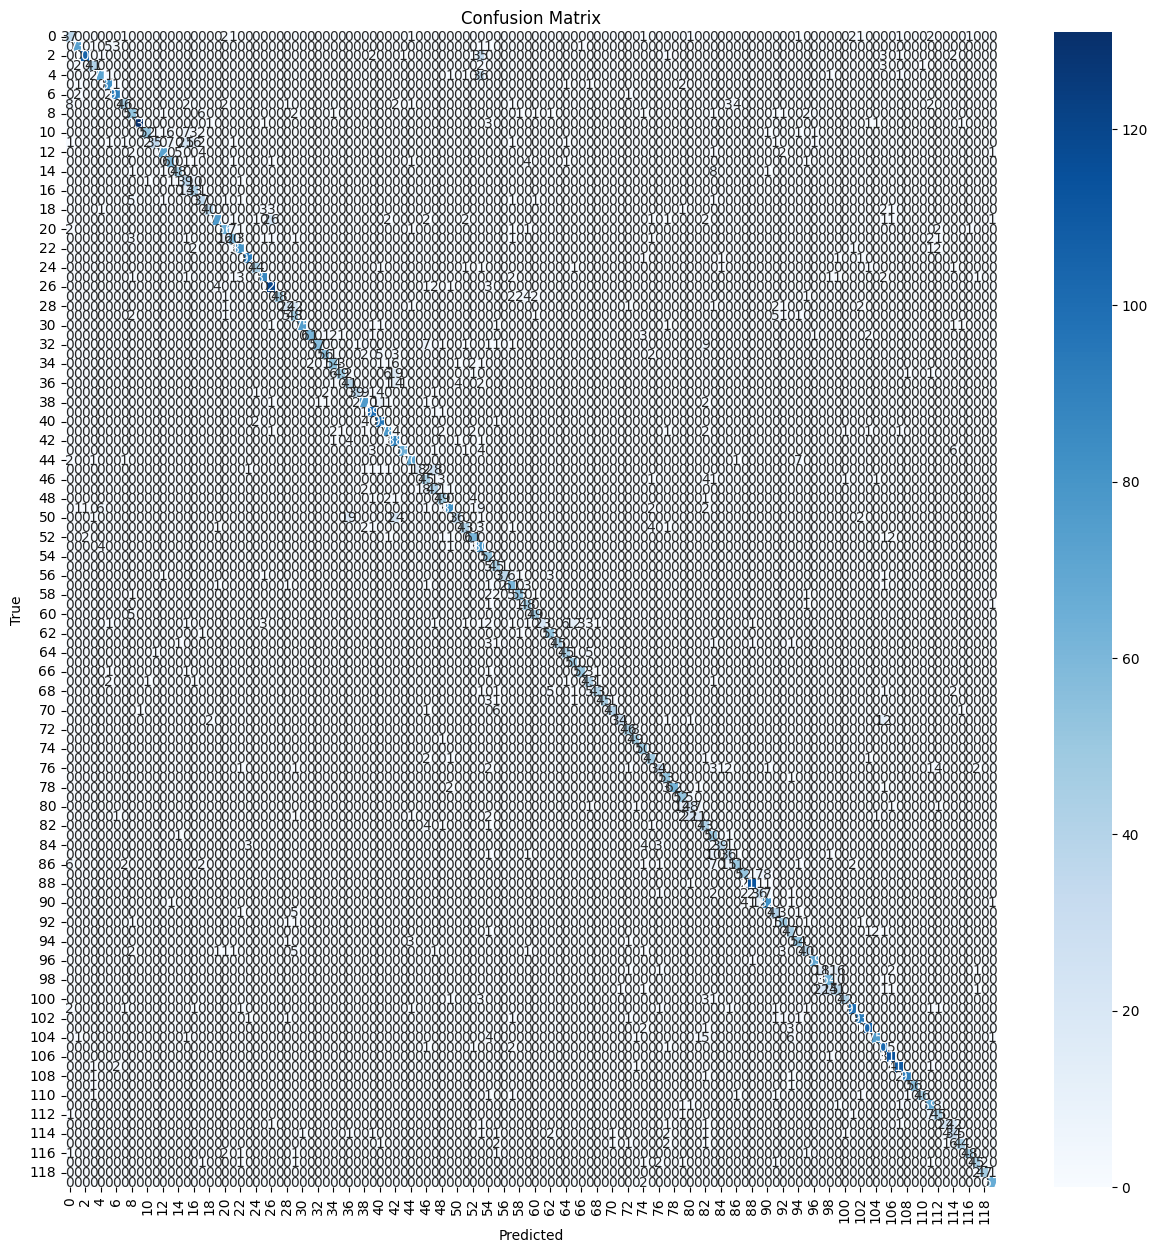

In [23]:
# Predictions
predicted_batches = resnet_50_3_model.predict(test_set_tune)
predicted_classes = np.argmax(predicted_batches, axis=1)

# Collect labels into a list
true_labels = [y.numpy() for x, y in test_set_tune.unbatch()]

# Convert the list of labels to a NumPy array
true_labels = np.array(true_labels)

# Check if the lengths match
if len(true_labels) == len(predicted_classes):
    # Create the confusion matrix
    cm = confusion_matrix(true_labels, predicted_classes)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Mismatch in the length of true labels and predicted labels")
    print("Length of true labels:", len(true_labels))
    print("Length of predicted labels:", len(predicted_classes))

### Write-up

1. Preprocessing    
After loading packages and data, I primarily selected two models: AlexNet and ResNet50. The reason for choosing these two models is that both the AlexNet model and the ResNet model are primarily suited for image classification. The difference between them is that AlexNet is for simple image classification, while ResNet is for deep image classification. For the latter, the computing cost might be higher, but the effectiveness is theoretically better.  
Firstly, I resized the data for the AlexNet, converting all images in the Stanford Dog dataset to a format of 277x277, which is the default size for AlexNet. Then, I normalized their pixel values. For the ResNet50 model, I also resized the images, but this time to ResNet's default size of 224x224, and used the built-in preprocess_input() function of ResNet for further processing. This function is mainly used for Pixel Value Scaling and Color Channel Ordering. After this, I checked the data structures of these two models to ensure their batch size shape and Image batch shape.  
2. Model implementation  
First, I built an AlexNet model. The model has a total of 5 convolutional layers, some followed by max-pooling layers, designed to extract features from the input images and followed by flattening the output and passing it through two dense (fully connected) layers with ReLU activation and dropout for regularization. The final dense layer with softmax activation is used for classifying the input into one of the 120 classes. After training the AlexNet model 10 times using the train set and evaluating it with the test set, I found that the performance of the AlexNet model was not satisfactory. The highest accuracy achieved was only 0.007, and the highest validation accuracy was just 0.01. Additionally, the loss rate reached around 5, which is not satisfactory for a model.  
After this I built a ResNet-50 model. I created the base ResNet-50 model pre-trained on the dataset and removed the top layer of the network, which allows for custom layers to be added for specific tasks. Then, I added three custom layers. I used a Global Average Pooling layer to reduce the spatial dimensions (height and width) of the output feature map from the base model to a vector. Next, I included a Dense Layer as a fully connected layer with 1024 neurons and ReLU (Rectified Linear Unit) activation. Finally, I added an Output Layer with 120 neurons and softmax activation, suitable for multi-class classification. At the same time, I froze the base model layers, allowing the model to retain learned features from ImageNet and only learn new patterns in the added layers for the specific task.  
After training the ResNet50 model 10 times using the train set and testing it with the test set, I achieved quite good results, and the computing cost did not increase significantly. The accuracy reached around 0.98, and the validation accuracy was about 0.75. However, there was an issue of overfitting, and the loss rate started to increase after a certain point in the training. Therefore, I decided to proceed with the ResNet50 model and make further improvements.  
I changed the image format in preprocessing to 300x300, which could enhance the resolution of the images. Additionally, I incorporated early stopping to prevent overfitting.  
After making the adjustments, the model stopped training at the 8th epoch. This time, the accuracy reached an impressive 0.9886, with a loss of only 0.0452. The validation accuracy was high at 0.8238, and the validation loss was 0.6488. This indicates that this round of training was more reliable than before and managed to minimize the impact of overfitting as much as possible.
3. Challenges  
In the process of training the model, the first problem I encountered was that the model's accuracy was too low, making it unusable. To address this issue, I abandoned the AlexNet model and switched to the ResNet-50 model, which has higher accuracy and deeper learning capabilities. After adopting the ResNet-50 model, I faced issues of overfitting and increasing loss rate. Therefore, I chose to increase the resolution of the images and added early stopping to prevent these problems.
4. Model Review   
Despite the successful tuning of the ResNet-50 model, there were still some issues present. The model performed impressively, with surprising accuracy levels, but there was still about a 0.15 gap between the accuracy and validation accuracy. This suggests that the model still had some overfitting issues. Additionally, due to the increased resolution of the images, the model's training time was longer. Perhaps further adjustments in the preprocessing stage could yield even better results.